# Installing necessary libraries

In [1]:
!pip install imutils
!pip install keras_cv
!pip install keras_core

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=a5dd705f89d803842f7ff40820526a1ac8f55535140c8c04278bb8a105a30246
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 9.7 MB/s eta 0:00:00a 0:00:01


# Importing necessary libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import pandas as pd
from textwrap import wrap
import keras_cv
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data pre-processing

## Resizing Images (256x256) 

In [3]:
input_folder = '/kaggle/input/Images'
output_folder = '/kaggle/working/Resized_Images'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        image = Image.open(os.path.join(input_folder, filename))
        image = image.resize((256, 256))
        image.save(os.path.join(output_folder, filename))

## Visualizing Images

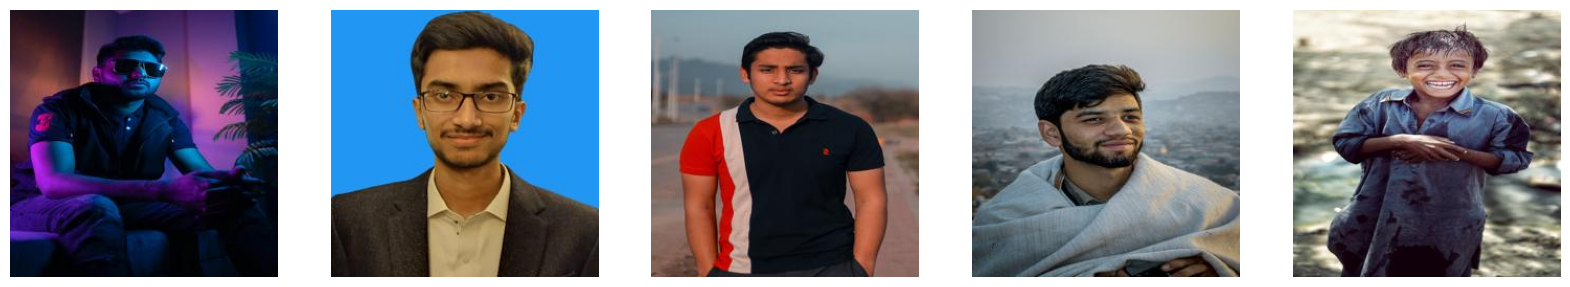

In [4]:
instance_image_paths = list(paths.list_images('/kaggle/working/Resized_Images'))

def load_images(image_paths):
    images = []
    for path in image_paths:
        image = Image.open(path)
        images.append(np.array(image))
    return images

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(load_images(instance_image_paths[:5]))

## Creating dataframe consisting of image paths and relevant captions

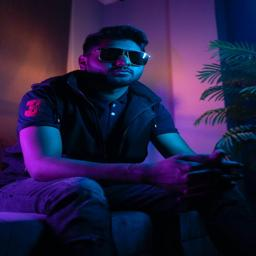

Enter a caption for the image:  A pakistani men


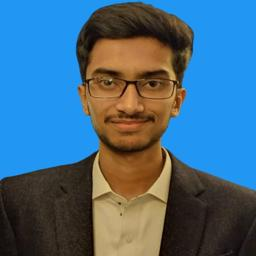

Enter a caption for the image:  A pakistani men


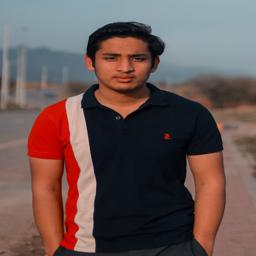

Enter a caption for the image:  A pakistani men


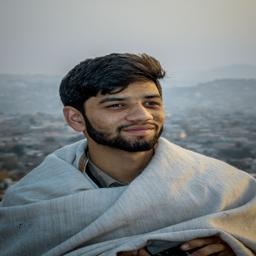

Enter a caption for the image:  A pakistani men


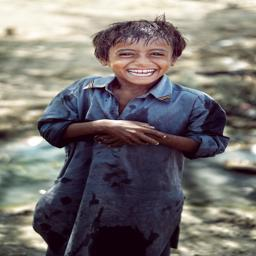

Enter a caption for the image:  A pakistani child


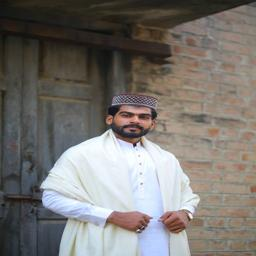

Enter a caption for the image:  A pakistani men


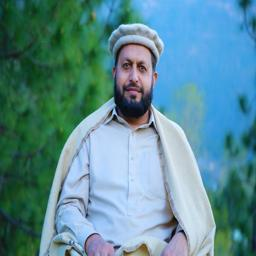

Enter a caption for the image:  A pakistani men


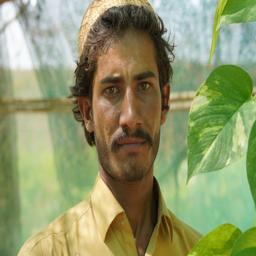

Enter a caption for the image:  A pakistani men


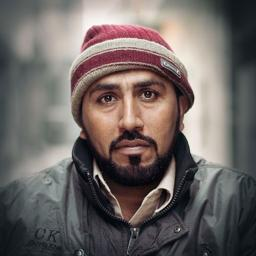

Enter a caption for the image:  A pakistani men


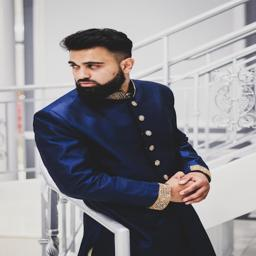

Enter a caption for the image:  A pakistani men


,image_path,caption
0,/kaggle/working/Resized_Images/free-photo-of-i...,A pakistani men
1,/kaggle/working/Resized_Images/Fahad Abdullah ...,A pakistani men
2,/kaggle/working/Resized_Images/photo-164715148...,A pakistani men
3,/kaggle/working/Resized_Images/photo-162196088...,A pakistani men
4,/kaggle/working/Resized_Images/pexels-photo-14...,A pakistani child
5,/kaggle/working/Resized_Images/pexels-photo-85...,A pakistani men
6,/kaggle/working/Resized_Images/pexels-photo-12...,A pakistani men
7,/kaggle/working/Resized_Images/free-photo-of-l...,A pakistani men
8,/kaggle/working/Resized_Images/photo-159864179...,A pakistani men
9,/kaggle/working/Resized_Images/photo-153421746...,A pakistani men


In [7]:
from IPython.display import Image, display

folder_path = output_folder

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

data = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    display(Image(filename=image_path))
    caption = input("Enter a caption for the image: ")

    data.append({'image_path': image_path, 'caption': caption})

df = pd.DataFrame(data)
df

In [8]:
data_frame = df
csv_filename = '/kaggle/working/df.csv'
df.to_csv(csv_filename, index=False)
print(f"DataFrame saved as {csv_filename}")

DataFrame saved as /kaggle/working/df.csv


## Prepare the datasets in the format expected by the text-to-image model

In [9]:
data_frame = pd.read_csv('/kaggle/working/df.csv')

### Preparing the captions

In [10]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


### Preparing the Images

In [11]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)

def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

492466864/492466864 [==============================] - 6s 0us/step


### Assembling the dataset

In [12]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


## Text-to-image Diffusion Model Training Loop

In [13]:
class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

## Fine-tuning Distributed training

In [14]:
USE_MP = False

cpu_strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with cpu_strategy.scope():
    image_encoder = ImageEncoder(RESOLUTION)
    diffusion_ft_trainer = Trainer(
        diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
        vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-2].output,
        ),
        noise_scheduler=NoiseScheduler(),
        use_mixed_precision=USE_MP,
    )

    lr = 1e-5
    beta_1, beta_2 = 0.9, 0.999
    weight_decay = (1e-2,)
    epsilon = 1e-08

    optimizer = tf.keras.optimizers.experimental.AdamW(
        learning_rate=lr,
        weight_decay=weight_decay,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
    )
    diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

    epochs = 10
    ckpt_path = "finetuned_stable_diffusion.h5"
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        save_weights_only=True,
        monitor="loss",
        mode="min",
    )

    diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])


3439090152/3439090152 [==============================] - 21s 0us/step
Epoch 1/10
3/3 [==============================] - 236s 27s/step - loss: 0.2491
Epoch 2/10
3/3 [==============================] - 101s 33s/step - loss: 0.2999
Epoch 3/10
3/3 [==============================] - 100s 33s/step - loss: 0.0300
Epoch 4/10
3/3 [==============================] - 103s 34s/step - loss: 0.0708
Epoch 5/10
3/3 [==============================] - 102s 33s/step - loss: 0.2193
Epoch 6/10
3/3 [==============================] - 100s 33s/step - loss: 0.1359
Epoch 7/10
3/3 [==============================] - 101s 33s/step - loss: 0.0779
Epoch 8/10
3/3 [==============================] - 100s 33s/step - loss: 0.0877
Epoch 9/10
3/3 [==============================] - 102s 33s/step - loss: 0.1126
Epoch 10/10
3/3 [==============================] - 102s 34s/step - loss: 0.2272


## Inference

In [15]:
# Replace this with the actual local path to the weights file
weights_path = "/kaggle/working/finetuned_stable_diffusion.h5"

img_height = img_width = 256
model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
model.diffusion_model.load_weights(weights_path)


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [16]:
prompts = []
images_to_generate = 3
outputs = {}

num_prompts = int(input("Enter the number of prompts: "))
for _ in range(num_prompts):
    prompt = input("Enter a prompt: ")
    prompts.append(prompt)

for prompt in prompts:
    generated_images = model.text_to_image(
        prompt, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})

Enter the number of prompts:  2
Enter a prompt:  a pakistani men
Enter a prompt:  a pakistani child


50/50 [==============================] - 449s 9s/step


## Results

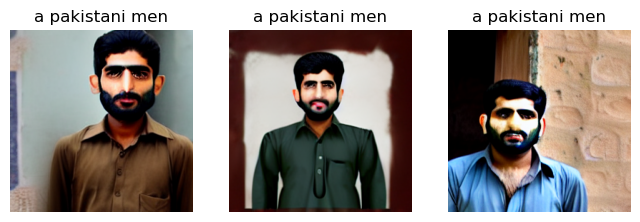

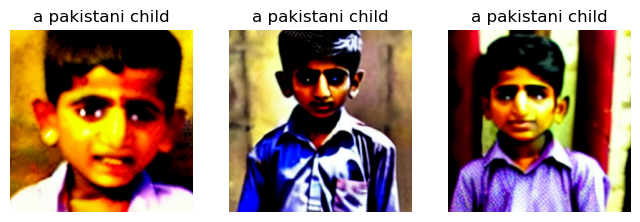

In [17]:
def plot_images(images, title):
    plt.figure(figsize=(8, 5))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)